In [1]:
import pandas as pd
import requests
from datetime import datetime
from sqlalchemy import create_engine
import os
uri = os.environ.get('URI')


url = 'https://api.blockchain.info/charts/transactions-per-second?timespan=all&sampled=false&metadata=false&cors=true&format=json'

resp = requests.get(url)


In [2]:
data = pd.DataFrame(resp.json()["values"])

# from timestamp to date
data['x'] = [datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') for x in data['x']]
data['x'] = pd.to_datetime(data['x'])

In [3]:
data.columns = ["date", "transactions"]
data.head()

,date,transactions
0,2016-06-11 00:00:00,1.983333
1,2016-06-11 00:15:00,1.966667
2,2016-06-11 00:30:00,1.900000
3,2016-06-11 00:45:00,2.283333
4,2016-06-11 01:00:00,2.083333


In [4]:
data['date'] = data['date'].dt.round('H')
grouped_data = data.groupby('date').sum().reset_index()

grouped_data.tail()


,date,transactions
68621,2024-04-10 13:00:00,20.100000
68622,2024-04-10 14:00:00,45.950000
68623,2024-04-10 15:00:00,17.500000
68624,2024-04-10 16:00:00,27.183333
68625,2024-04-10 17:00:00,5.566667


#### Neptune.ai code was missing, setting frequency to dataframe index

In [5]:
# set frequency as hourly
grouped_data = grouped_data.set_index('date')
grouped_data = grouped_data.asfreq("H")
grouped_data.tail()

,transactions
date,
2024-04-10 13:00:00,20.100000
2024-04-10 14:00:00,45.950000
2024-04-10 15:00:00,17.500000
2024-04-10 16:00:00,27.183333
2024-04-10 17:00:00,5.566667


In [6]:
steps = 36
n_datos_entrenar = 200

train_data = grouped_data[ -n_datos_entrenar:-steps]
test_data  = grouped_data[-steps:]

In [7]:
#from utils import create_predictors
from skforecast.model_selection import grid_search_forecaster
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 

# imports for data reading
import requests
from datetime import datetime

# imports for Neptune
import os
from dotenv import load_dotenv
import neptune

/home/michal/documents/MLOps-pipeline-github-actions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Zwykły fit, bez opcji z param_grid() - nie będzie optymalny

In [8]:
# Define forecaster
forecaster_rf = ForecasterAutoreg(
                    regressor      = RandomForestRegressor(random_state=123),
                    #fun_predictors = create_predictors,
                    lags    = 20
                )

In [11]:
forecaster_rf.fit(y=train_data["transactions"])
forecaster_rf

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2024-04-02 10:00:00'), Timestamp('2024-04-09 05:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-04-10 19:41:32 
Last fit date: 2024-04-10 19:42:

In [12]:
steps = 36
predictions = forecaster_rf.predict(steps=steps)
predictions.head(5)

2024-04-09 06:00:00    18.760333
2024-04-09 07:00:00    15.593167
2024-04-09 08:00:00    23.810833
2024-04-09 09:00:00    21.697500
2024-04-09 10:00:00    29.202500
Freq: H, Name: pred, dtype: float64

In [13]:
test_data.head()

,transactions
date,
2024-04-09 06:00:00,20.083333
2024-04-09 07:00:00,13.233333
2024-04-09 08:00:00,19.666667
2024-04-09 09:00:00,10.283333
2024-04-09 10:00:00,21.233333


##### How would non grid prediction perform?

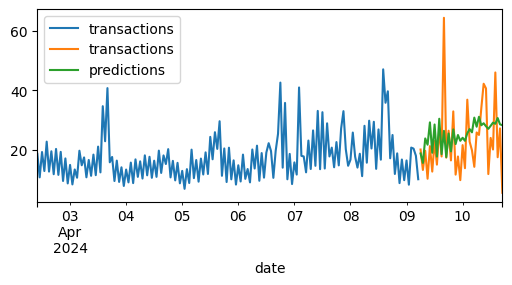

In [14]:
fig, ax = plt.subplots(figsize=(6, 2.5))
train_data.plot(ax=ax, label='train')
test_data.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

##### USE GRID PARAMETERS

In [15]:
param_grid = { 'n_estimators': [100, 500], 'max_depth': [3, 5, 10] }

In [17]:
grid_results = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = train_data["transactions"],
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        initial_train_size    = int(len(train_data)*0.5),
                        allow_incomplete_fold = True,
                        return_best = True, # return only ONE best grid
                        verbose     = False
                    )

Number of models compared: 6.


lags grid: 100%|██████████| 1/1 [00:08<00:00,  8.18s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 91.4281548761977



In [27]:
# grid results presented as DataFrame
grid_results

,lags,params,mean_squared_error,max_depth,n_estimators
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",91.428155,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",92.391238,3,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",93.870887,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",93.972079,10,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",94.465240,10,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",94.641179,5,100


In [23]:
# predictions variable is the result of running grid_search_forecast() with return_best parameter
predictions.tail()

2024-04-10 13:00:00    29.113333
2024-04-10 14:00:00    28.721833
2024-04-10 15:00:00    30.655167
2024-04-10 16:00:00    28.547667
2024-04-10 17:00:00    28.243167
Freq: H, Name: pred, dtype: float64

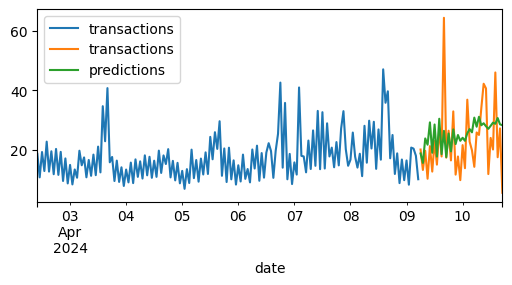

In [24]:
fig, ax = plt.subplots(figsize=(6, 2.5))
train_data.plot(ax=ax, label='train')
test_data.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();